In [1]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import fitz
from PIL import Image

In [2]:
with open('rows_data.json', 'r') as json_file:
    rows_json = json.load(json_file)

In [3]:
def rebuild_row_image(row_obj, original_image):
    """
    Собираем "слитное" изображение строки, но сохраняем исходное
    вертикальное смещение каждого символа внутри row_obj.cells.
    
    Предполагается, что symbol.y хранит "верх" символа *локально* в пределах ячейки,
    но можно и глобально хранить, нужно только быть согласованным.
    """
    import cv2
    import numpy as np

    symbols_to_place = []
    
    for cell in row_obj.cells:
        # Глобальные координаты ячейки (или локальные, зависит от вашей логики).
        cell_x, cell_y = int(cell.x), int(cell.y)
        cell_img = original_image[cell_y:cell_y+cell.h, cell_x:cell_x+cell.w]

        for sym in cell.symbols:
            sx, sy, sw, sh = int(sym.x), int(sym.y), int(sym.w), int(sym.h)
            # Вырез символа:
            sym_img = cell_img[sy:sy+sh, sx:sx+sw]
            
            # Координата Y в глобальной системе row'а:
            # т.к. sy - локальная внутри cell, надо сложить с cell_y, чтобы получить глобальную.
            # Но если row_obj.cells идут подряд, вы можете трактовать "row_y_min" как минимум из всех ячеек.
            # Для демонстрации запишем "глобальную" верхнюю точку символа:
            global_y = cell_y + sy
            
            symbols_to_place.append((sym_img, global_y))

    if not symbols_to_place:
        return None

    # Сортируем символы по порядку cells? 
    # Вопрос: нужно ли сначала сортировать по ячейкам (или уже отсортированы) 
    # и внутри ячейки — по x. Предположим, что уже упорядочено (или сделайте manual sort).

    # Найдём minY и maxY+H по всем символам:
    min_y = min(g_y for (_, g_y) in symbols_to_place)
    # max_y = max(g_y + sym_img.shape[0] for (sym_img, g_y) in symbols_to_place)

    # Теперь собираем всё в "одну строку" по горизонтали, но с учётом вертикального смещения.
    # Заведём current_x = 0, будем шагать по каждому символу.
    
    # Определим высоту финального row_image, как разницу между min_y и max из (g_y + h).
    max_bottom = max(g_y + s.shape[0] for (s, g_y) in symbols_to_place)
    total_height = max_bottom - min_y

    # Считаем суммарную ширину (просто сумма ширин символов)
    total_width = sum(s.shape[1] for (s, _) in symbols_to_place)

    row_image = np.full((total_height, total_width, 3), 255, dtype=np.uint8)  # белый BGR
    # transform row_image to gray
    row_image = cv2.cvtColor(row_image, cv2.COLOR_BGR2GRAY)
    current_x = 0
    for sym_img, g_y in symbols_to_place:
        h_sym, w_sym = sym_img.shape[:2]
        # "верх" символа внутри row_image 
        # = (g_y - min_y), т.е. сохраняем сдвиг относительно верхней границы row_image
        offset_y = g_y - min_y

        # Вырезаем ROI:
        roi = row_image[offset_y:offset_y + h_sym, current_x:current_x + w_sym]
        if roi.shape[:2] == sym_img.shape[:2]:
            row_image[offset_y:offset_y + h_sym, current_x:current_x + w_sym] = sym_img
        else:
            # на всякий случай, если что-то не совпало
            hh = min(roi.shape[0], sym_img.shape[0])
            ww = min(roi.shape[1], sym_img.shape[1])
            row_image[offset_y:offset_y + hh, current_x:current_x + ww] = sym_img[:hh,:ww]

        current_x += w_sym  # сдвигаем вправо для следующего символа

    return row_image

def place_row_image_into_form(row_obj, original_image):
    """
    Берём row_image из rebuild_row_image(...) и вставляем в bounding box строки,
    закрасив предварительно область белым.
    """
    # 1. Считаем bounding box всей строки (пробегаем по клеткам, берём min/max x и y).
    # Для наглядности реализуем тут же (или используем row_obj.get_contour()).
    x_coords = [int(c.x) for c in row_obj.cells]
    y_coords = [int(c.y) for c in row_obj.cells]
    x_maxs = [int(c.x + c.w) for c in row_obj.cells]
    y_maxs = [int(c.y + c.h) for c in row_obj.cells]

    x_min = min(x_coords)
    y_min = min(y_coords)
    x_max = max(x_maxs)
    y_max = max(y_maxs)

    # 2. Собираем картинку строки
    row_image = rebuild_row_image(row_obj, original_image)
    if row_image is None:
        return  # Нет символов, ничего вставлять

    # 3. Заливаем исходный bounding box белым
    cv2.rectangle(
        original_image,
        (x_min, y_min),
        (x_max, y_max),
        (255, 255, 255),
        thickness=-1
    )

    # 4. Вырезаем «целевой регион» (ROI) в original_image, куда будем помещать row_image
    target_width = x_max - x_min
    target_height = y_max - y_min

    # Если row_image больше или меньше по размеру, решаем, хотим ли «подгонять»
    row_h, row_w = row_image.shape[:2]

    # Для примера: подгоним row_image по ширине (сохраняя соотношение сторон)
    scale = target_width / row_w
    new_w = int(row_w * scale)
    new_h = int(row_h * scale)

    # Проверим, не вылезет ли он по высоте
    if new_h > target_height:
        # если вылазит — придётся ещё масштабировать по высоте
        scale2 = target_height / new_h
        new_w = int(new_w * scale2)
        new_h = int(new_h * scale2)

    # Масштабируем
    row_image_resized = cv2.resize(row_image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Теперь размещаем (начиная с (x_min, y_min))
    # Если хотим по центру — можно сдвинуть, если хотим в левом верхнем углу bounding box — без сдвига
    # Возьмём левый верх:
    paste_x = x_min
    paste_y = y_min

    # Вставляем row_image_resized в original_image
    # Нужно не выйти за границы массива:
    region = original_image[paste_y:paste_y+new_h, paste_x:paste_x+new_w]

    if region.shape[:2] == row_image_resized.shape[:2]:
        original_image[paste_y:paste_y+new_h, paste_x:paste_x+new_w] = row_image_resized
    else:
        # На всякий случай проверка (если что-то не так с размерами)
        hh = min(region.shape[0], row_image_resized.shape[0])
        ww = min(region.shape[1], row_image_resized.shape[1])
        original_image[paste_y:paste_y+hh, paste_x:paste_x+ww] = row_image_resized[:hh, :ww]

def get_aligned_pic(template, filled, scale_factor = 0.25):

    # 1. Считываем два изображения
    height, width = template.shape[:2]
    template = cv2.resize(template, (int(height*scale_factor), int(width*scale_factor)), interpolation=cv2.INTER_AREA)

    # Приведение заполненного бланка к размеру и разрешению шаблона
    filled = cv2.resize(filled, (template.shape[1], template.shape[0]), interpolation=cv2.INTER_AREA)

    # Нахождение ключевых точек и дескрипторов
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(filled, None)

    # Сопоставление точек
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Используем лучшие сопоставления
    good_matches = matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Вычисление матрицы гомографии
    matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Применение перспективного преобразования
    h, w = template.shape[:2]
    aligned_image = cv2.warpPerspective(filled, matrix, (w, h))

    aligned_image = cv2.resize(aligned_image, (width, height), interpolation=cv2.INTER_AREA)
    # Сохранение результата
    cv2.imwrite('aligned_form.jpg', aligned_image)

    return aligned_image

def get_contours(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Инвертируем изображение (пунктирные линии должны быть белыми)
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Применяем размытие, чтобы убрать шум
    blurred = cv2.GaussianBlur(binary, (5, 5), 0)

    # Используем морфологию для выделения прямоугольных структур
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    processed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Поиск контуров
    contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: x[0][0][1])
    contours = sorted(contours, key=lambda x: x[0][0][0])
    contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

    # Копия изображения для отображения результатов
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Фильтруем и выделяем только прямоугольные блоки
    contours_valid = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Условие для фильтрации блоков по размеру
        if 100 < w < 150 and 100 < h < 200:  # Подстраивайте размеры под бланк
            contours_valid.append(contour)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return contours_valid, output

def visualize_row(contours, image_path):
    # Копия изображения для отображения результатов
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Фильтруем и выделяем только прямоугольные блоки
    contours_valid = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Условие для фильтрации блоков по размеру
        if 100 < w < 150 and 100 < h < 200:  # Подстраивайте размеры под бланк
            contours_valid.append(contour)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return output

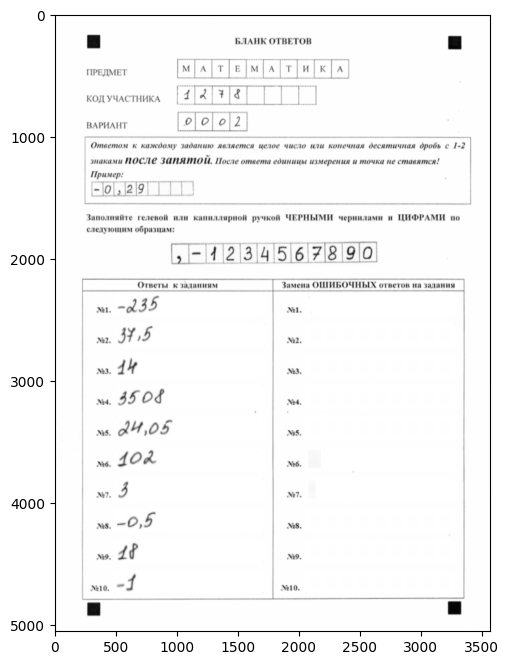

In [28]:
class Symbol:
    """
    Класс символа с координатами и распознанным значением.
    Координаты (x, y, w, h) можно трактовать как локальные
    относительно выреза ячейки, или как глобальные — 
    по вашему выбору.
    """
    def __init__(self, x, y, w, h, value=None):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.value = value

    def __repr__(self):
        return f"Symbol(x={self.x}, y={self.y}, w={self.w}, h={self.h}, value={self.value})"

class Cell:
    def __init__(self, row_name):
        """
        Класс, представляющий одну клетку.
        
        :param row_name: Название строки, к которой относится клетка
        """
        self.row_name = row_name
        self.cell_number = None
        self.x = None
        self.y = None
        self.w = None
        self.h = None
        self.value = None
        self.cell_number = None
        self.symbols = []

    def __repr__(self):
        return (f"Cell(row_name={self.row_name}, cell_number={self.cell_number}, "
                f"x={self.x}, y={self.y}, w={self.w}, h={self.h}, "
                f"value={self.value}, symbols={self.symbols})")
    
    def detect_symbol_in_cell(self, image):
        x_cell = int(self.x or 0)
        y_cell = int(self.y or 0)
        w_cell = int(self.w or 0)
        h_cell = int(self.h or 0)

        cell_img = image[y_cell:y_cell + h_cell, x_cell:x_cell + w_cell]
        global test_cell_img
        test_cell_img = cell_img
        gray = cell_img
        _, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        self.symbols = []
        if len(contours) > 0:
            # Предположим, что самый крупный контур — это наш символ
            cnt = max(contours, key=cv2.contourArea)
            x_sym, y_sym, w_sym, h_sym = cv2.boundingRect(cnt)

            # OCR (опционально)
            symbol_crop = gray[y_sym:y_sym+h_sym, x_sym:x_sym+w_sym]
            # symbol_value = pytesseract.image_to_string(symbol_crop, ...)

            symbol = Symbol(x=x_sym, y=y_sym, w=w_sym, h=h_sym, value=None)
            self.symbols.append(symbol)

    def load_from_dict(self, cell_dict):
        """
        Заполняем поля клетки из словаря (обычно загружается из JSON).
        """
        self.x = cell_dict.get("x")
        self.y = cell_dict.get("y")
        self.w = cell_dict.get("w")
        self.h = cell_dict.get("h")
        self.value = cell_dict.get("value")
        self.cell_number = cell_dict.get("cell_number")

class Row:
    def __init__(self, row_name):
        self.row_name = row_name
        self.x = None
        self.y = None
        self.w = None
        self.h = None
        # Сразу создаём 10 объектов Cell
        # (каждому можно проставить cell_number = i)
        if row_name == "subject":
            self.cells = [Cell(row_name) for _ in range(10)]
        elif row_name == "user_id":
            self.cells = [Cell(row_name) for _ in range(8)]
        elif row_name == "version":
            self.cells = [Cell(row_name) for _ in range(4)]
        else:
            self.cells = [Cell(row_name) for _ in range(9)]
        self.correct_answers = []

    def get_contour(self):
        """
        Возвращает (x, y, w, h) — bounding box по всей строке,
        делая полный проход по cells.
        """
        if not self.cells:
            return None  # или (0,0,0,0)

        x_coords = [cell.x for cell in self.cells]
        y_coords = [cell.y for cell in self.cells]
        x_right_edges = [cell.x + cell.w for cell in self.cells]
        y_bottom_edges = [cell.y + cell.h for cell in self.cells]

        x_min = min(x_coords)
        y_min = min(y_coords)
        x_max = max(x_right_edges)
        y_max = max(y_bottom_edges)

        w = x_max - x_min
        h = y_max - y_min
        self.x = x_min
        self.y = y_min
        self.w = w
        self.h = h
        return (x_min, y_min, w, h)

    def load_data(self, row_dict):
        """
        row_dict ожидается вида:
        {
          "cell1": { "x": ..., "y": ... },
          "cell2": { "x": ..., "y": ... },
          ...
        }
        """
        for i in range(10):
            cell_key = f"cell{i}"  # cell1..cell10
            if cell_key in row_dict:
                # self.cells[i].cell_number = i + 1
                self.cells[i].load_from_dict(row_dict[cell_key])
                # print(self.cells[i])

    def __repr__(self):
        return f"Row('{self.row_name}', cells={self.cells})"

class Form:
    # Определяем все названия строк, которые хотим использовать
    ROW_NAMES = (
        ["subject", "user_id", "version"]
        + [f"answer{i}" for i in range(1, 11)]
        + [f"correction{i}" for i in range(1, 11)]
    )

    def __init__(self, contours=None):
        """
        contours — возможно, вам нужно передавать сюда какие-то контуры или
        иной массив данных, но для упрощённого примера можно оставить как есть.
        """
        # Вместо того, чтобы вручную создавать self.subject, self.user_id, ...
        # делаем это в цикле.

        for row_name in self.ROW_NAMES:
            setattr(self, row_name, Row(row_name))
        
        self.image = None
        self.template = None

    def __repr__(self):
        # Тоже можно собрать строку динамически
        # (но если вам удобнее - оставьте вручную)
        rows_repr = []
        for row_name in self.ROW_NAMES:
            row_obj = getattr(self, row_name)
            rows_repr.append(f"{row_name}={row_obj}")
        rows_repr_str = ", ".join(rows_repr)
        return f"Form({rows_repr_str})"

    def load_meta_from_json(self, json_path):
        """
        Читаем файл JSON и заполняем все поля (строки).
        Структура JSON должна быть такая, чтобы для каждого row
        (subject, user_id, version, answer1..answer10, correction1..correction10)
        были данные по cell1..cellN (зависит от Row).
        """
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            # print(data) 

        # Вместо повторяющегося if "answer1" in data: self.answer1.load_data(...)
        # можно пройтись по всем row_name:
        for row_name in self.ROW_NAMES:
            if row_name in data:
                row_obj = getattr(self, row_name)  # Получаем экземпляр Row
                row_obj.load_data(data[row_name])

    @staticmethod
    def number_to_list(number):
        # Преобразуем число в строку
        number_str = str(number)

        # Преобразуем строку в список символов
        result = list(number_str.replace('.', ','))

        return result

    def load_correct_answers(self, answers):
        version = self.version.cells[0].value
        version = 1
        answers = answers[answers['Вариант'] == version].reset_index(drop=True)

        for i in range(1, 11):
            answers[i] = answers[i].astype(str)

        # Append correct answers and update cell values
        for i in range(1, 11):
            answer_attr = getattr(self, f'answer{i}')
            correct_answer = answers.iloc[0, i]
            answer_attr.correct_answers.append(correct_answer)
            
            answers_cells = self.number_to_list(correct_answer)
            for j, cell_value in enumerate(answers_cells):
                answer_attr.cells[j].value = cell_value

    def get_symbals_from_image(self):
        image = self.image
        for row_name in ([f"answer{i}" for i in range(1, 11)] + [f"correction{i}" for i in range(1, 11)]):
            row_obj = getattr(self, row_name)
            for cell in row_obj.cells:
                cell.detect_symbol_in_cell(image)

    def get_sybmol_row(self):
        original_image = self.image
        for row_name in [f"answer{i}" for i in range(1, 11)] + [f"correction{i}" for i in range(1, 11)]:
            row_obj = getattr(self, row_name)
            place_row_image_into_form(row_obj, original_image)

        cv2.imwrite("modified_form.png", original_image)

    def remove_cells_lines(self):
        for row_name in [f"answer{i}" for i in range(1, 11)] + [f"correction{i}" for i in range(1, 11)]:
            row_obj = getattr(self, row_name)
            for cell in row_obj.cells:
                x, y, w, h = cell.x, cell.y, cell.w, cell.h
                scale = 20
                scale_2 = 5
                self.image[y - scale : y + scale, x - scale_2 : x + w + scale_2] = 255,   
                self.image[y + h - scale : y + h + scale, x - scale_2 : x + w + scale_2] = 255
                self.image[y - scale_2 : y + h + scale_2, x - scale : x + scale] = 255
                self.image[y - scale_2 : y + h + scale_2, x + w - scale : x + w + scale] = 255
        cv2.imwrite("removed_cells_lines.png", self.image)


    def load_image(self, image):
        self.image = image
    
    def load_template(self, template_path):
        self.template = cv2.imread(template_path)

    def align_form(self, scale_factor = 0.25):
        aligned_image = get_aligned_pic(self.template, self.image, scale_factor)
        self.image = aligned_image

    def visualize_form(self):
        for row_name in [f"answer{i}" for i in range(1, 11)] + [f"correction{i}" for i in range(1, 11)]:
            row_obj = getattr(self, row_name)
            for cell in row_obj.cells:
                x, y, w, h = cell.x, cell.y, cell.w, cell.h
                cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imwrite("visualized_form.png", self.image)

    def run_pipeline(self, image, template_path, json_path, answers):
        form = Form()
        form.load_meta_from_json(json_path)
        form.load_correct_answers(answers)
        form.load_image(image)
        form.load_template(template_path)
        form.align_form(scale_factor = 0.3)
        form.remove_cells_lines()
        form.get_symbals_from_image()
        form.get_sybmol_row()


        plt.figure(figsize=(10, 8))
        plt.imshow(form.image, cmap='gray')
        plt.show()

        return form

def get_pic_from_pdf(pdf_document, index, zoom=1.5):
    """
    Получает изображение страницы из PDF
    :param pdf_stream: поток PDF файла
    :param index: индекс страницы
    :return: серое изображение страницы
    """
    # Открываем PDF из байтового потока
    page = pdf_document.load_page(index)  # Загружаем страницу
    mat = fitz.Matrix(zoom, zoom)  # Матрица для увеличения изображения
    pix = page.get_pixmap(matrix=mat)  # Преобразуем страницу в изображение
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    img_gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    return img_gray



pdf_document = fitz.open("test_pics/valid_format/Сканы бланков ответов 20.01.2025.pdf")
num_pages = pdf_document.page_count

cur_pic = get_pic_from_pdf(pdf_document, 2)
answers = pd.read_excel("answers.xlsx")
form = Form()
form = form.run_pipeline(
    image = cur_pic,
    template_path = "template.jpg",
    json_path = "rows_data.json",
    answers = answers
)



In [21]:
form.answer1


Row('answer1', cells=[Cell(row_name=answer1, cell_number=0, x=510, y=2300, w=126, h=154, value=-, symbols=[Symbol(x=20, y=77, w=46, h=23, value=None)]), Cell(row_name=answer1, cell_number=1, x=642, y=2300, w=129, h=154, value=9, symbols=[Symbol(x=22, y=43, w=74, h=76, value=None)]), Cell(row_name=answer1, cell_number=2, x=777, y=2300, w=126, h=154, value=8, symbols=[Symbol(x=30, y=39, w=63, h=76, value=None)]), Cell(row_name=answer1, cell_number=3, x=909, y=2300, w=126, h=154, value=None, symbols=[Symbol(x=29, y=39, w=55, h=81, value=None)]), Cell(row_name=answer1, cell_number=4, x=1041, y=2300, w=129, h=154, value=None, symbols=[]), Cell(row_name=answer1, cell_number=5, x=1176, y=2300, w=126, h=154, value=None, symbols=[]), Cell(row_name=answer1, cell_number=6, x=1308, y=2300, w=126, h=154, value=None, symbols=[]), Cell(row_name=answer1, cell_number=7, x=1440, y=2300, w=129, h=154, value=None, symbols=[]), Cell(row_name=answer1, cell_number=8, x=1576, y=2300, w=125, h=154, value=None,

In [30]:
form.visualize_form()



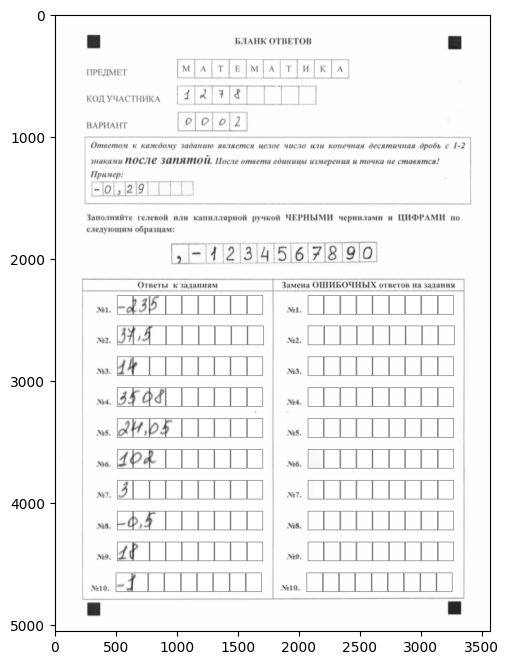

In [31]:
cur_pic

plt.figure(figsize=(10, 8))
plt.imshow(form.image, cmap='gray')
plt.show()


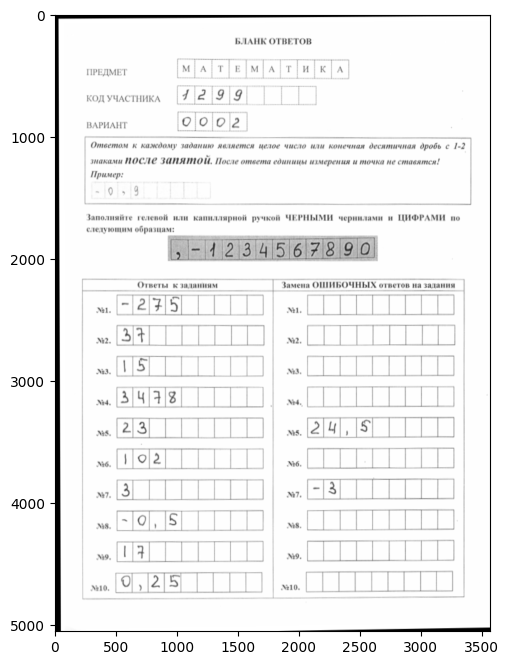

In [8]:
def get_aligned_pic(template, filled, scale_factor = 0.25):

    # 1. Считываем два изображения
    height, width = template.shape[:2]
    template = cv2.resize(template, (int(height*scale_factor), int(width*scale_factor)), interpolation=cv2.INTER_AREA)

    # Приведение заполненного бланка к размеру и разрешению шаблона
    filled = cv2.resize(filled, (template.shape[1], template.shape[0]), interpolation=cv2.INTER_AREA)

    # Нахождение ключевых точек и дескрипторов
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(filled, None)

    # Сопоставление точек
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Используем лучшие сопоставления
    good_matches = matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Вычисление матрицы гомографии
    matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Применение перспективного преобразования
    h, w = template.shape[:2]
    aligned_image = cv2.warpPerspective(filled, matrix, (w, h))

    aligned_image = cv2.resize(aligned_image, (width, height), interpolation=cv2.INTER_AREA)
    # Сохранение результата
    cv2.imwrite('aligned_form.jpg', aligned_image)

    return aligned_image

def remove_cells_lines(self):
    for row_name in [f"answer{i}" for i in range(1, 11)] + [f"correction{i}" for i in range(1, 11)]:
        row_obj = getattr(self, row_name)
        for cell in row_obj.cells:
            x, y, w, h = cell.x, cell.y, cell.w, cell.h
            scale = 10
            scale_2 = 5
            self.image[y - scale : y + scale, x - scale_2 : x + w + scale_2] = 255,   
            self.image[y + h - scale : y + h + scale, x - scale_2 : x + w + scale_2] = 255
            self.image[y - scale_2 : y + h + scale_2, x - scale : x + scale] = 255
            self.image[y - scale_2 : y + h + scale_2, x + w - scale : x + w + scale] = 255
    cv2.imwrite("removed_cells_lines.png", self.image)


template = cv2.imread("template.jpg")
cur_pic = get_pic_from_pdf(pdf_document, 1)
aligned_pic = get_aligned_pic(template, cur_pic)

plt.figure(figsize=(10, 8))
plt.imshow(aligned_pic, cmap='gray')
plt.show()


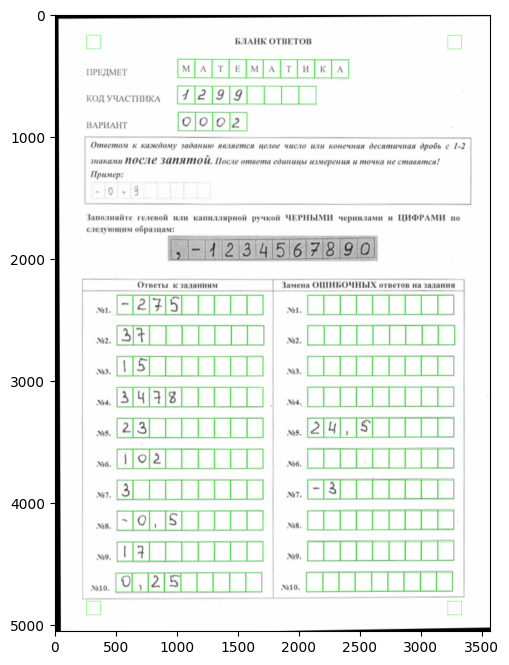

In [12]:
def get_contours(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Инвертируем изображение (пунктирные линии должны быть белыми)
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Применяем размытие, чтобы убрать шум
    blurred = cv2.GaussianBlur(binary, (5, 5), 0)

    # Используем морфологию для выделения прямоугольных структур
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    processed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Поиск контуров
    contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: x[0][0][1])
    contours = sorted(contours, key=lambda x: x[0][0][0])
    contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

    # Копия изображения для отображения результатов
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Фильтруем и выделяем только прямоугольные блоки
    contours_valid = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Условие для фильтрации блоков по размеру
        if 100 < w < 150 and 100 < h < 200:  # Подстраивайте размеры под бланк
            contours_valid.append(contour)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return contours_valid, output

def get_image_with_contours(template_path, filled_path):
    filled = cv2.imread(filled_path)
    contours_valid, output = get_contours(template_path)
    for contour in contours_valid:
        x, y, w, h = cv2.boundingRect(contour)  
        cv2.rectangle(filled, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return filled


# contours_valid, output = get_contours("template.jpg")

image_with_contours = get_image_with_contours("template.jpg", "aligned_form.jpg")

plt.figure(figsize=(10, 8))
plt.imshow(image_with_contours, cmap='gray')
plt.show()
